![alt text](../img/general/header.png)

## High-Level Synthesis for Machine Learning (hls4ml)


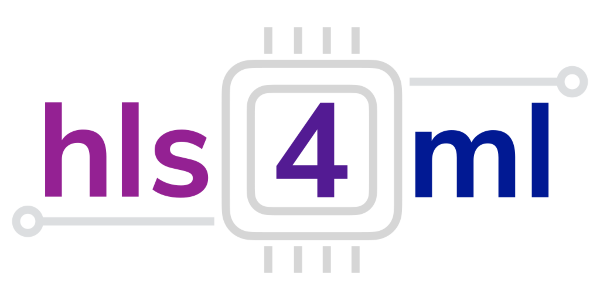

💡 **High-Level Synthesis for Machine Learning (hls4ml)** es una biblioteca de código abierto diseñada para convertir modelos de aprendizaje automático en descripciones de hardware optimizadas para su implementación en FPGAs 

**Características de hls4ml:** 

- Convierte modelos de Keras, TensorFlow, PyTorch, y ONNX en proyectos HLS (High-Level Synthesis).

- Usa herramientas como Xilinx Vitis HLS y Intel HLS Compiler para generar código en C++ optimizado para hardware.

- Permite reducir la latencia y el consumo de energía, mejorando la eficiencia en implementaciones de IA en edge computing.

- Soporta técnicas de cuantización y pruning para reducir el tamaño del modelo sin afectar significativamente su precisión.

**Aplicaciones de hls4ml:**

- Procesamiento en tiempo real en sistemas embebidos.

- Implementación de redes neuronales en hardware de baja potencia.

- Aceleración de modelos de IA en aplicaciones como física de partículas, visión artificial y robótica.


Para más información:

- GitHub: https://github.com/fastmachinelearning/hls4ml

- Web site: https://fastmachinelearning.org/hls4ml/

---

### Librerías

In [2]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import * # type: ignore
from tensorflow.keras.layers import * # type: ignore
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import hls4ml
import matplotlib.pyplot as plt


2025-04-10 20:52:45.547647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 20:52:45.581778: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 20:52:45.582370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 20:52:46.457715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Path a Vitis HLS


Como paso inicial se debe especificar el directorio de instalación de Vivado HLS o Vitis HLS. 

In [3]:
# Path donde se encuentra instalado Vitis HLS!! 

os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# Para MÁQUINA VIRTUAL!
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.2/bin/vitis_hls:' + os.environ['PATH']

os.environ['PATH']


'/tools/Xilinx/Vitis_HLS/2022.2/bin/vitis_hls:/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:/home/student/miniconda3/envs/neuralEnv/bin:/tools/Xilinx/Vitis_HLS/2022.2/bin:/tools/Xilinx/Vitis/2022.2/bin:/tools/Xilinx/Vitis/2022.2/gnu/microblaze/lin/bin:/tools/Xilinx/Vitis/2022.2/gnu/arm/lin/bin:/tools/Xilinx/Vitis/2022.2/gnu/microblaze/linux_toolchain/lin64_le/bin:/tools/Xilinx/Vitis/2022.2/gnu/aarch32/lin/gcc-arm-linux-gnueabi/bin:/tools/Xilinx/Vitis/2022.2/gnu/aarch32/lin/gcc-arm-none-eabi/bin:/tools/Xilinx/Vitis/2022.2/gnu/aarch64/lin/aarch64-linux/bin:/tools/Xilinx/Vitis/2022.2/gnu/aarch64/lin/aarch64-none/bin:/tools/Xilinx/Vitis/2022.2/gnu/armr5/lin/gcc-arm-none-eabi/bin:/tools/Xilinx/Vitis/2022.2/tps/lnx64/cmake-3.3.2/bin:/tools/Xilinx/Vitis/2022.2/aietools/bin:/tools/Xilinx/Vivado/2022.2/bin:/tools/Xilinx/Vitis_HLS/2022.2/bin:/tools/Xilinx/Vitis/2022.2/bin:/tools/Xilinx/Vitis/2022.2/gnu/microblaze/lin/bin:/tools/Xilinx/Vitis/2022.2/gnu/arm/lin/bin:/tools/Xilinx/Vitis/2022

### Carga del modelo (.h5)

Carga del modelo pre-entrenado y guardado en formato **.h5**. 

Para este laboratorio, el modelo fue generado en el **lab03**.

In [31]:
from qkeras.utils import _add_supported_quantized_objects
# for quantization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule

co = {}
_add_supported_quantized_objects(co)

model_fname = 'latest_QAT-KD_MNIST'

model = load_model(f'{model_fname}.h5', custom_objects=co) # type: ignore
    
# Resumen del modelo
model.summary()

/home/student/miniconda3/envs/neuralEnv/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "quantizedStudentModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 4)                 3140      
                                                                 
 relu1 (QActivation)         (None, 4)                 0         
                                                                 
 fc2 (QDense)                (None, 3)                 15        
                                                                 
 relu2 (QActivation)         (None, 3)                 0         
                                                                 
 fc3 (QDense)                (None, 2)                 8         
                                                                 
 relu3 (QActivation)         (None, 2)                 0         
                                                                 
 output (QDense)             (None, 10)      

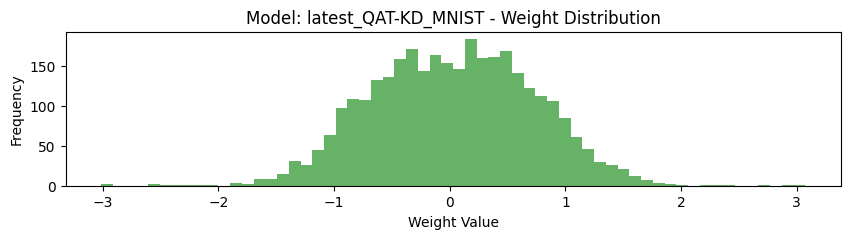

0.002959728240966797 

the exponent is the minimum number of digits to difference two different weigths


In [32]:
# Weight distribution
weights = np.concatenate([w.flatten() for w in model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=60, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title(f"Model: {model_fname} - Weight Distribution")
plt.show()

min_diff = 1

for i in range(1, len(weights)):

    wvec = weights[i]*np.ones(i)

    diffvec = np.abs(weights[0:i]-wvec)
    
    new_diffvec = [item for item in diffvec if item != 0]

    new_min_diff = np.min(new_diffvec)
    if min_diff > new_min_diff:
        min_diff = new_min_diff

print(new_min_diff, '\n')

print("the exponent is the minimum number of digits to difference two different weigths")

### hls4ml 

💡 Arbitrary precision reference: https://docs.amd.com/r/2022.2-English/ug1399-vitis-hls/Fixed-Point-Identifier-Summary?tocId=jgeN4rPFF_M6nxbDn1H5HA

In [33]:

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

import plotting

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 3]
Layer name: relu2, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc3, layer type: QDense, input shapes: [[None, 3]], output shape: [None, 2]
Layer name: relu3, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Layer name: output, layer type: QDense, input shapes: [[None, 2]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  

In [34]:
from hls4ml.model.profiling import numerical, get_ymodel_keras

# the name of the different layers could be different!! 

# hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'  
# hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<8, 2>'  
# hls_config['LayerName']['relu_input']['Precision'] = 'ap_fixed<8, 3>'

hls_config['LayerName']['softmax']['Strategy'] = 'Stable'
hls_config['Model']['Precision'] = 'ap_fixed<3,3>'



### hls4ml con Vitis HLS como backend

In [ ]:
cfg = hls4ml.converters.create_config(backend='Vitis')

# cfg['IOType']     = 'io_stream'     # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config      # HLS configuraiton
cfg['KerasModel'] = model           # Keras model to be converted
cfg['OutputDir']  = f'hlsPrj-model__{model_fname}/'       # Project name
cfg['Part'] = 'xc7z020clg484-1'     # PYNQ-Z1 or Zedboard: xc7z020clg484-1  ARTIX-7 xc7a35tcsg325-1  # MPSoC xczu4eg-sfvc784-2-e  xczu3eg-sfvc784-1-e

hls_model = hls4ml.converters.keras_to_hls(cfg)

hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 3]
Layer name: relu2, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc3, layer type: QDense, input shapes: [[None, 3]], output shape: [None, 2]
Layer name: relu3, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Layer name: output, layer type: QDense, input shapes: [[None, 2]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Creating HLS model
Writing HLS project


Done


In [ ]:
hls_model.build(csim=False, export=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'student' on host 'workspace' (Linux_x86_64 version 6.8.0-57-generic) on Fri Apr 11 08:06:12 CEST 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/student/Documents/cursoML2025/git/ML_FPGA_UNMdP/labs/lab5/hlsPrj-model__latest_QAT-KD_MNIST'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/student/Documents/cursoML2025/git/ML_FPGA_UNMdP/labs/lab5/hlsPrj-model__latest_QAT-KD_MNIST/myproject_prj'.
INFO: [HLS 200-1510] Running: set_top myprojec

----

#### 📝 Ejercicio

- Realizar el proceso de síntesis para distintos modelos con diferentes técnicas de compresión y efectuar una comparación de los resultados obtenidos (latencia y utilización de recursos). ¿Qué conclusiones puede sacar al vincular el hardware generado con la técnica de compresión empleada? Considerar MNIST o Fashion dataset, empleando MLP como arquitectura (sin _flatten_ en la primera capa). Considere:
    
    - Pruning + quantization ( 8 bits)
    
    - Quantization (16 bits)

    - Knowledge distillation 

Utilizando el modelo disponible en git, se probo usar ap_fixed<2,8> al ver el histograma de pesos, pero por alguna razón al crear el modelo hls, no habia ninguna utilización de elementos. Se aumento a <3,8> y se obtuvo la siguiente sintesis:

'TargetClockPeriod': '5.00',
'EstimatedClockPeriod': '4.327',
'BestLatency': '14',
'WorstLatency': '14',
'IntervalMin': '1',
'IntervalMax': '1',
'BRAM_18K': '1',
'DSP': '4',
'FF': '27106',
'LUT': '21028',
'URAM': '0',
'AvailableBRAM_18K': '280',
'AvailableDSP': '220',
'AvailableFF': '106400',
'AvailableLUT': '53200',
'AvailableURAM': '0'

Cargando un modelo personal, en el que se usan CNN con QAT y knowledge distillation (QAP tira error), se tienen la siguiente sintesis:

'TargetClockPeriod': '5.00',
'EstimatedClockPeriod': '4.213',
'BestLatency': '48',
'WorstLatency': '48',
'IntervalMin': '44',
'IntervalMax': '44',
'BRAM_18K': '5',
'DSP': '75',
'FF': '50970',
'LUT': '84691',
'URAM': '0',
'AvailableBRAM_18K': '280',
'AvailableDSP': '220',
'AvailableFF': '106400',
'AvailableLUT': '53200',
'AvailableURAM': '0'